In [1]:
import pandas as pd
import sys
sys.path.append('../')
from ada2023.utils import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip

## Setup

We process the Wikipedia Request for Adminship (RfA) dataset into a dataframe. We are using a [Wikipedia edit history dataset](https://snap.stanford.edu/data/wiki-meta.html) containing edit up to january 2008. Therefore we filter votes that aren't present in this timeframe.

In [2]:
df = pd.read_csv("../data/wiki-RfA-cleaned.csv")

# We filter out all the votations after 2008 as we do not have the edits for those dates
df = df[df.year_election < 2009]

#Set of users that are present in the adminship dataset
admin_set = set(df['source'].to_list() + df['target'].to_list())

In [3]:
len(admin_set)

8494

We consider an interaction between two users to be an edit from user A in the user talk page of user B. User talk page ["normal use is for messages from, and discussion with, other editors"](https://en.wikipedia.org/wiki/Wikipedia:User_pages). We filtered edits to keep only interactions from users that where present in the RfA dataset. Using those interactions we created an undirected graph where the weight is the number of interaction between the two users and each node is a user. (TODO : Check with Jeremy for more precise explanation).

In [4]:
G = create_interaction_graph()

To have a better understanding of the interactions, we plot them in a graph. We also plot the degree rank plot and histogram. The degree of a node is the number of edges adjacents to the node. This plot helps us to better understand the distribution of the number of adjacent nodes. We can see that most of the nodes have a low rank. (TODO : Check avec Robin si ok)

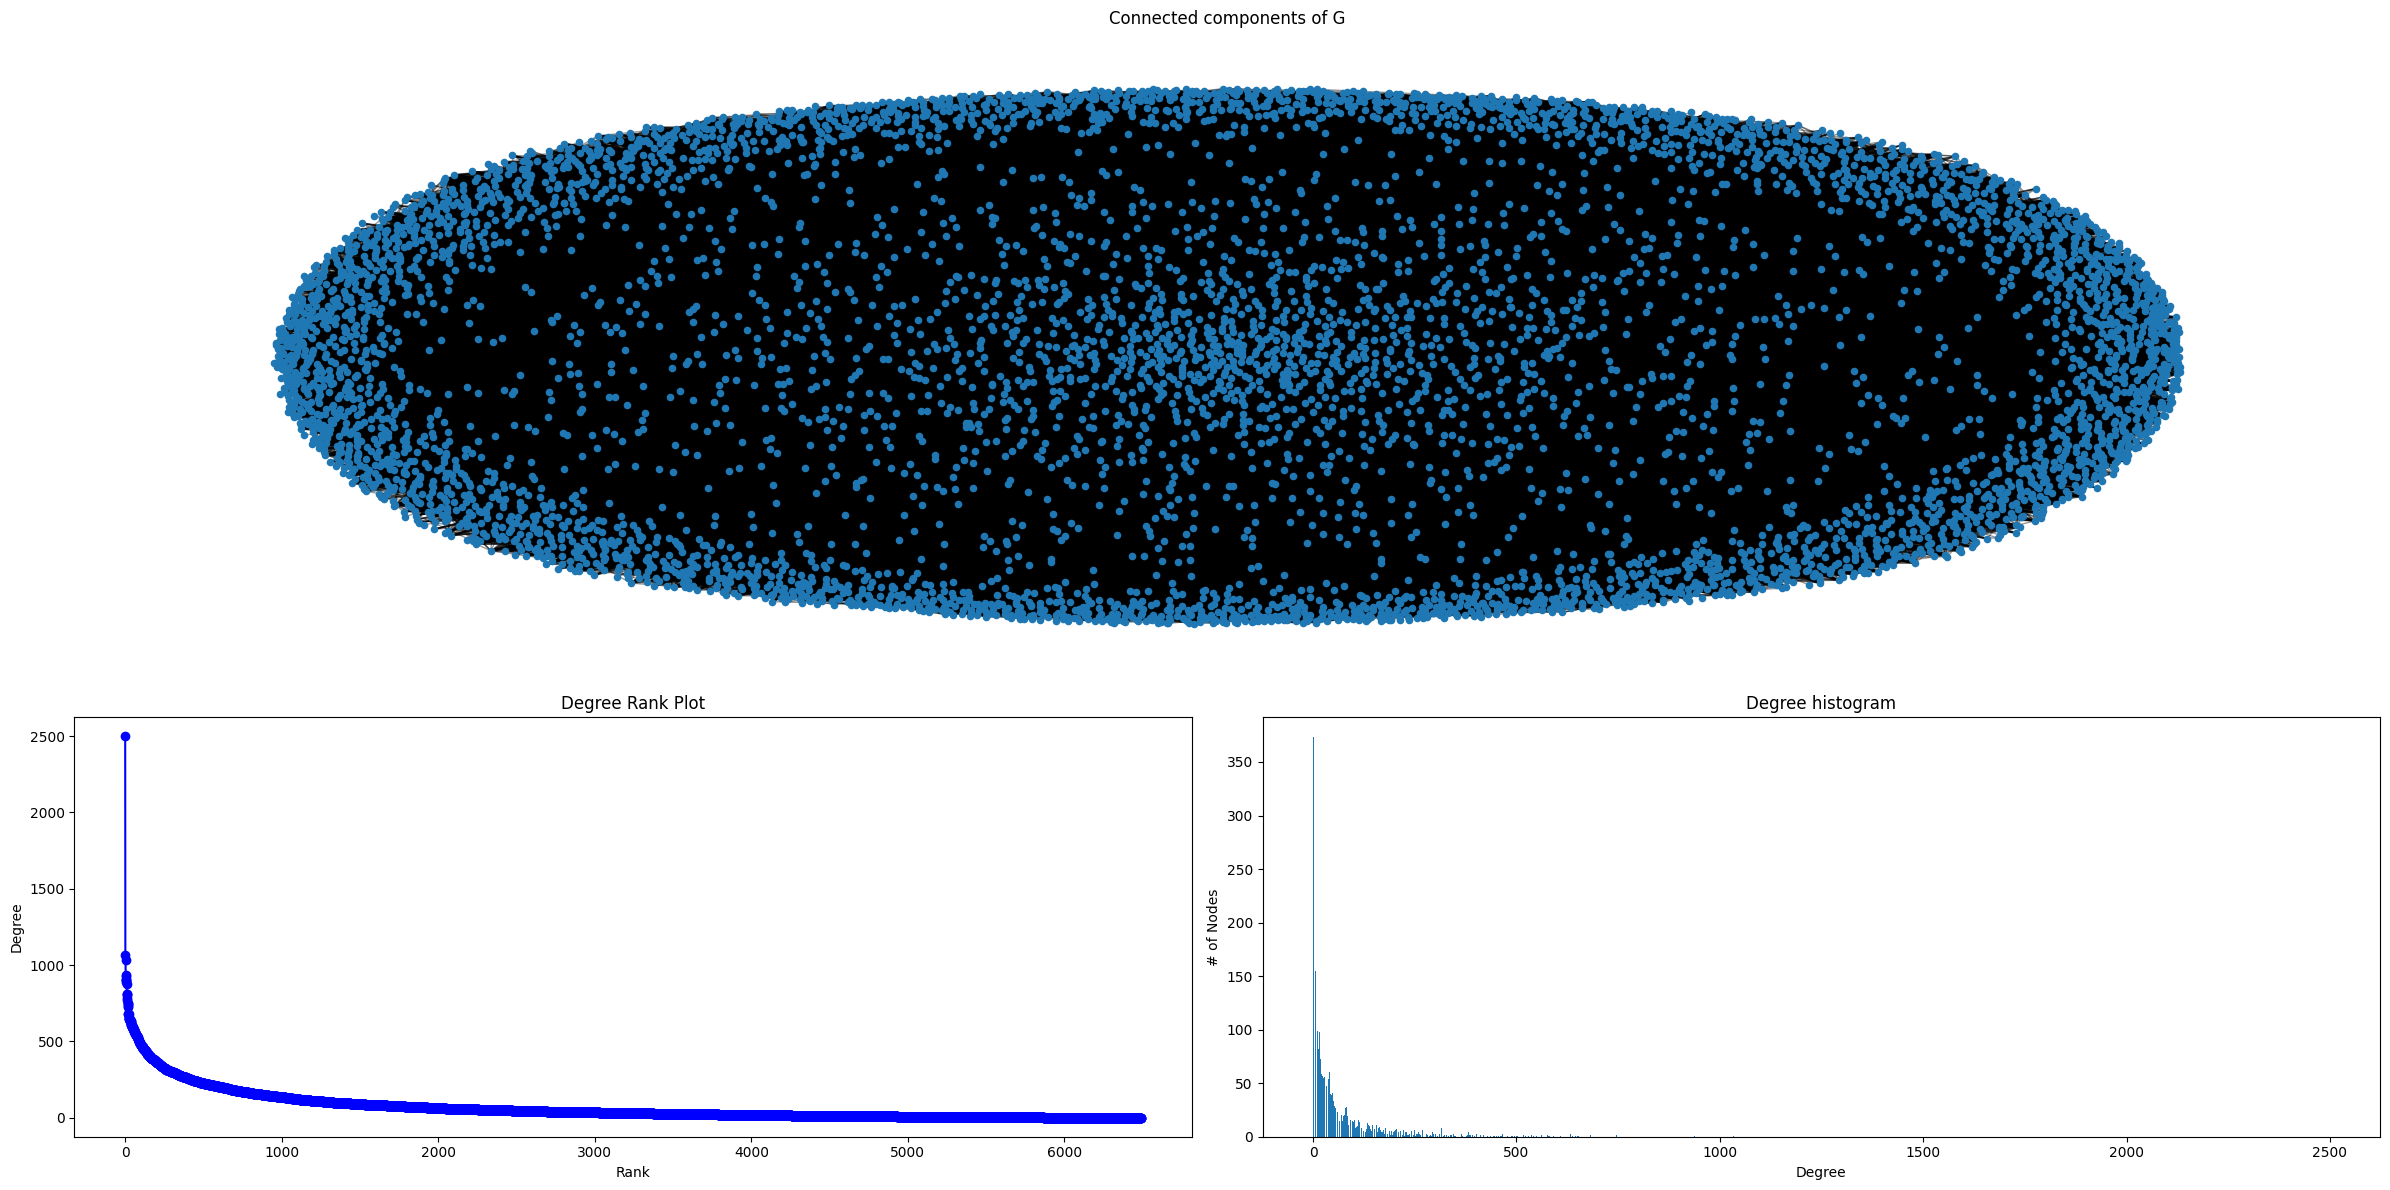

In [5]:
# We sort the nodes in the graph by their degree
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(24, 12))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

# Graph of the connected components
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, k=1, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

# Degree rank plot (TODO : demander si ylabel est bien "Degree" ou plutot "# of Nodes")
ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

# Degree histogram
ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [6]:
#We create the communities

# 3 paramètres qui donnent des résultats sympas
communities = nx.community.louvain_communities(G, resolution=1.5, seed=2)
#communities = nx.community.louvain_communities(G, resolution=1.7, seed=3)
#communities = nx.community.louvain_communities(G, resolution=1.2, seed=0)

In [7]:
print(f"Number of communities in graph of users with interactions : {len(communities)}")

Number of communities in graph of users with interactions : 29


In [8]:
partition_c = {}
for count, c in enumerate(communities):
    for u in c:
        partition_c[u] = count
node_colors = [partition_c[node] for node in G.nodes()]

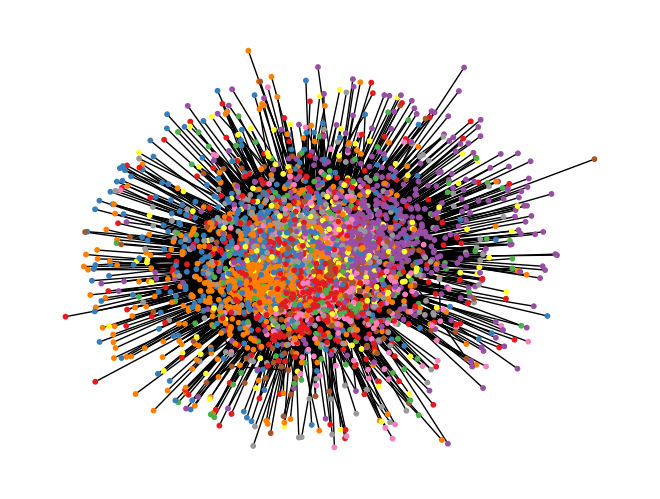

In [9]:
pos = nx.spring_layout(G)  # You can use other layouts like shell_layout, circular_layout, etc.

nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.Set1, node_size=10, font_size=8, font_color='black')

# Show the plot
plt.show()

To understand the influence of communities, we compute the probability of vote to be within your community if it was voted at random.

In [10]:
n = len(G) # Number of nodes in the graph
p_same_cluster = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster = np.array([])

# We compute the probability that a random vote is an intra-cluster vote
for c in communities:
    p_same_cluster += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster = np.append(array_p_same_cluster, (len(c)/n)*((len(c)-1)/n))
print(f"Probability that a random vote is an intra-cluster vote in interaction graph : {p_same_cluster:.2%}")

Probability that a random vote is an intra-cluster vote in interaction graph : 7.52%


In [11]:
# Initialize a counter for votes within the same community
intra_vote_count = np.zeros(len(communities))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities):
        if entity1 in community and entity2 in community:
            intra_vote_count[count] += 1

# Print the result
print(f"Number of votes within the same community : {int(intra_vote_count.sum())}")

Number of votes within the same community : 19719


In [12]:
# Initialize a counter for votes in the graph
votes_in_the_graph = 0

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the graph
    if entity1 in G and entity2 in G:
        votes_in_the_graph += 1

# Print the result
print(f"Number of votes in the graph : {votes_in_the_graph}")

Number of votes in the graph : 75956


We compare the probability of a random vote with what was observed. The goal is to assess whether the users vote is influenced by its community. We observe that we have a ~3x increase in probability to vote towards your own community.

In [13]:
print(f"Effective percentage of intra-cluster votes in G: {(intra_vote_count.sum()/votes_in_the_graph):.2%}")

Effective percentage of intra-cluster votes in G: 25.96%


In [14]:
print(f"Number of nodes (users) in the graph : {len(G)}")
print(f"Number of users in the RfA dataset : {len(admin_set)}")
print(f"Percentage of users in the graph : {(len(G)/len(admin_set)):.2%}")

Number of nodes (users) in the graph : 6491
Number of users in the RfA dataset : 8494
Percentage of users in the graph : 76.42%


To understand the increase in votes, we compute the expected number of votes if voted at random. Then we make the ratio to derive the multiplicative coefficient from the expected number of votes to observed. 

In [15]:
# expected number of intra-cluster votes
expected_nb_votes = array_p_same_cluster * votes_in_the_graph

In [16]:
# ratio of effective intra-cluster votes over expected intra-cluster votes
vote_gain = intra_vote_count / expected_nb_votes
vote_gain

array([0.6392672 , 1.95480449, 4.86297886, 1.91157321, 5.9868701 ,
       1.23228389, 4.80553428, 1.94402465, 3.54126525, 3.24072321,
       8.99406596, 4.22065953, 4.9601216 , 2.70220704, 5.58480564,
       4.18689145, 4.16147596, 2.79255912, 1.49058011, 7.9938516 ,
       4.10421568, 3.20941599, 2.75598089, 2.84808704, 2.01373183,
       3.31874062, 3.75161983, 3.75161983, 1.7773336 ])

In [17]:
for i, c in enumerate(communities):
    print(f"Community {i} has size {len(c)}")

Community 0 has size 503
Community 1 has size 299
Community 2 has size 59
Community 3 has size 57
Community 4 has size 153
Community 5 has size 138
Community 6 has size 587
Community 7 has size 206
Community 8 has size 89
Community 9 has size 79
Community 10 has size 52
Community 11 has size 1116
Community 12 has size 172
Community 13 has size 795
Community 14 has size 118
Community 15 has size 405
Community 16 has size 193
Community 17 has size 115
Community 18 has size 127
Community 19 has size 57
Community 20 has size 115
Community 21 has size 98
Community 22 has size 82
Community 23 has size 104
Community 24 has size 302
Community 25 has size 91
Community 26 has size 46
Community 27 has size 46
Community 28 has size 287


We want to understand the distribution of votes between communities. For that we plot the distribution of votes between communities

In [18]:
# Number of votes across communities
vote_count_matrix = np.zeros((len(communities), len(communities)))
nb_community_votes = np.zeros(len(communities))

In [19]:
def find_community(entity, communities):
    for count, community in enumerate(communities):
        if entity in community:
            return count

In [20]:
# Populate the vote count matrix
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        vote_count_matrix[i_src][i_dst] += 1
        nb_community_votes[i_src] += 1

In [21]:
# We verify our computations and transform the vote count matrix into a ratio matrix
np.testing.assert_array_equal(vote_count_matrix.sum(axis=1), nb_community_votes)
ratio_vote_count_matrix = (vote_count_matrix / nb_community_votes[:, np.newaxis])*100 
np.testing.assert_almost_equal(ratio_vote_count_matrix.sum(axis=1), np.ones(len(communities))*100)

In the plot we observe that the destination communities that recieve most of the votes are the larger communities. This is explained by the fact that for large communities, more votation take place and therefore more votes are directed to them.

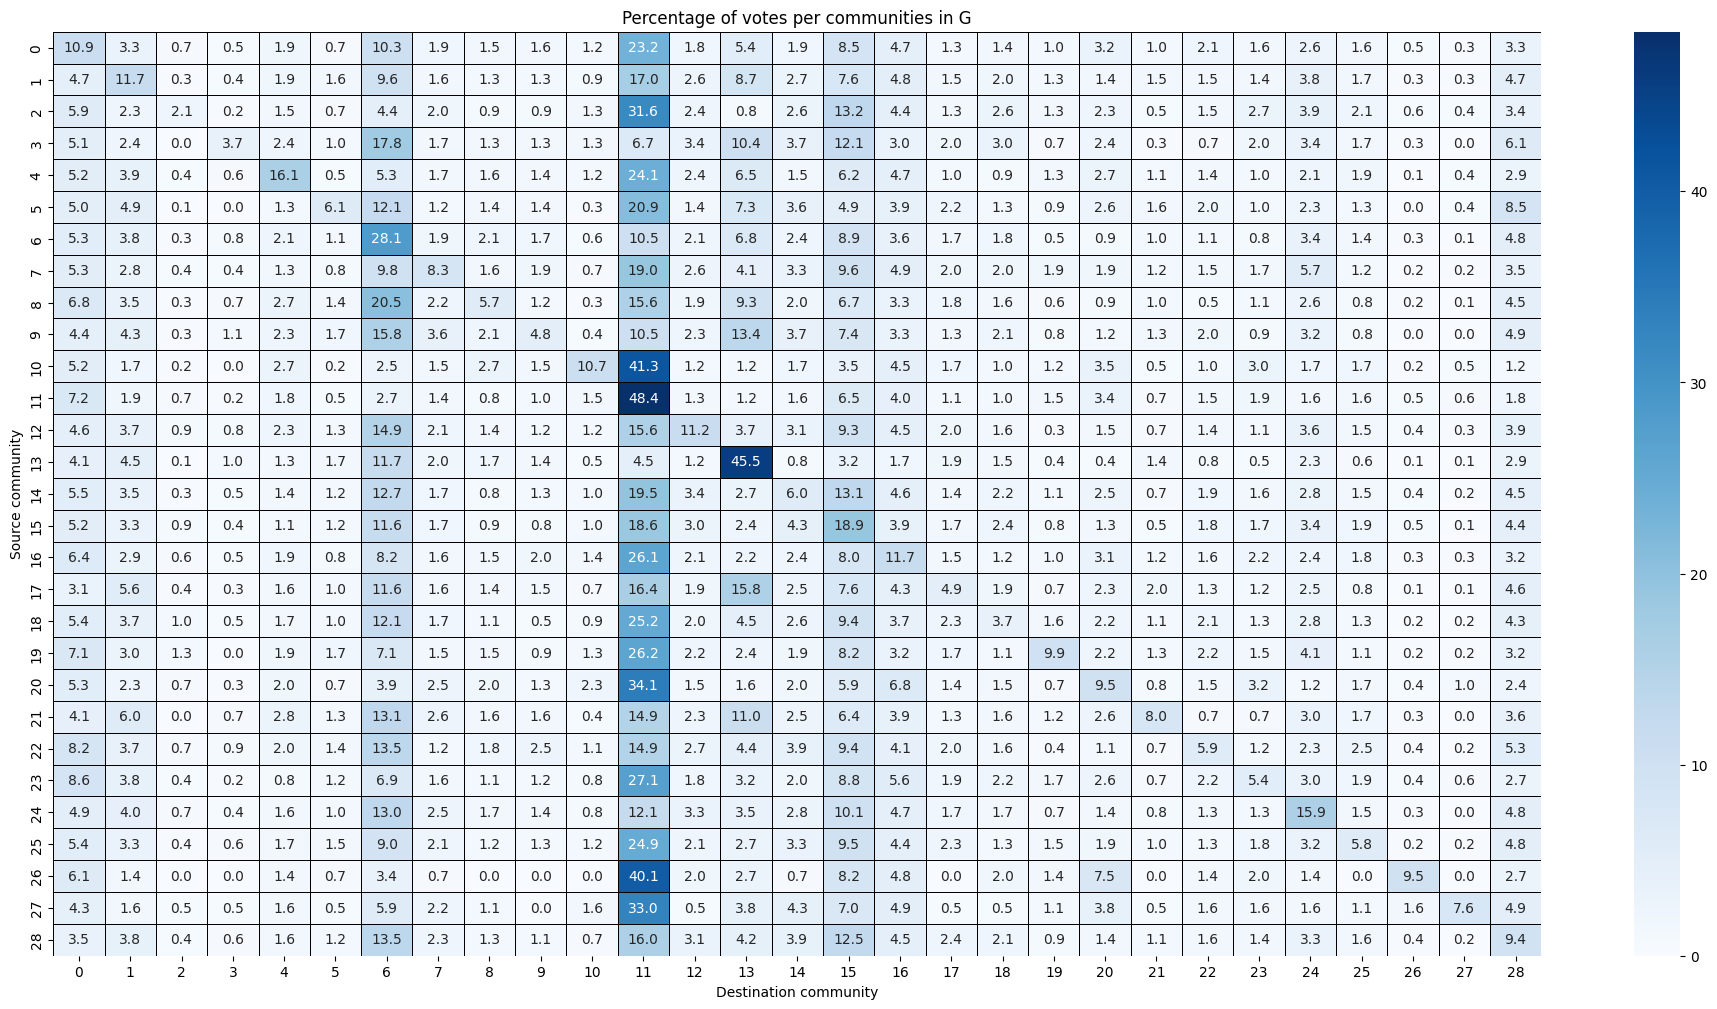

In [22]:
# Heatmap of the ratio of votes across communities
plt.figure(figsize=(24, 12))
sns.heatmap(ratio_vote_count_matrix, cmap="Blues", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

To mitigate this domination of the large communities, we scale the results by the probability of a vote between two communities given that the votes are random. We display the ratio of effective votes over expected votes for each pair of communities.

In [23]:
# Create matrix that represents the probability of a vote between two communities
prob_vote_community_matrix = np.zeros((len(communities), len(communities)))
for i_src in range(len(communities)):
    for i_dst in range(len(communities)):
        prob_vote_community_matrix[i_src][i_dst] = (len(communities[i_src])*len(communities[i_dst]))/(len(G)**2)
# create matrix that represents the expected number of votes between two communities
ratio_vote_expected_matrix = prob_vote_community_matrix * votes_in_the_graph

In [25]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [26]:
gain_vote_expected_matrix = np.nan_to_num(nb_result_votes / ratio_vote_expected_matrix)

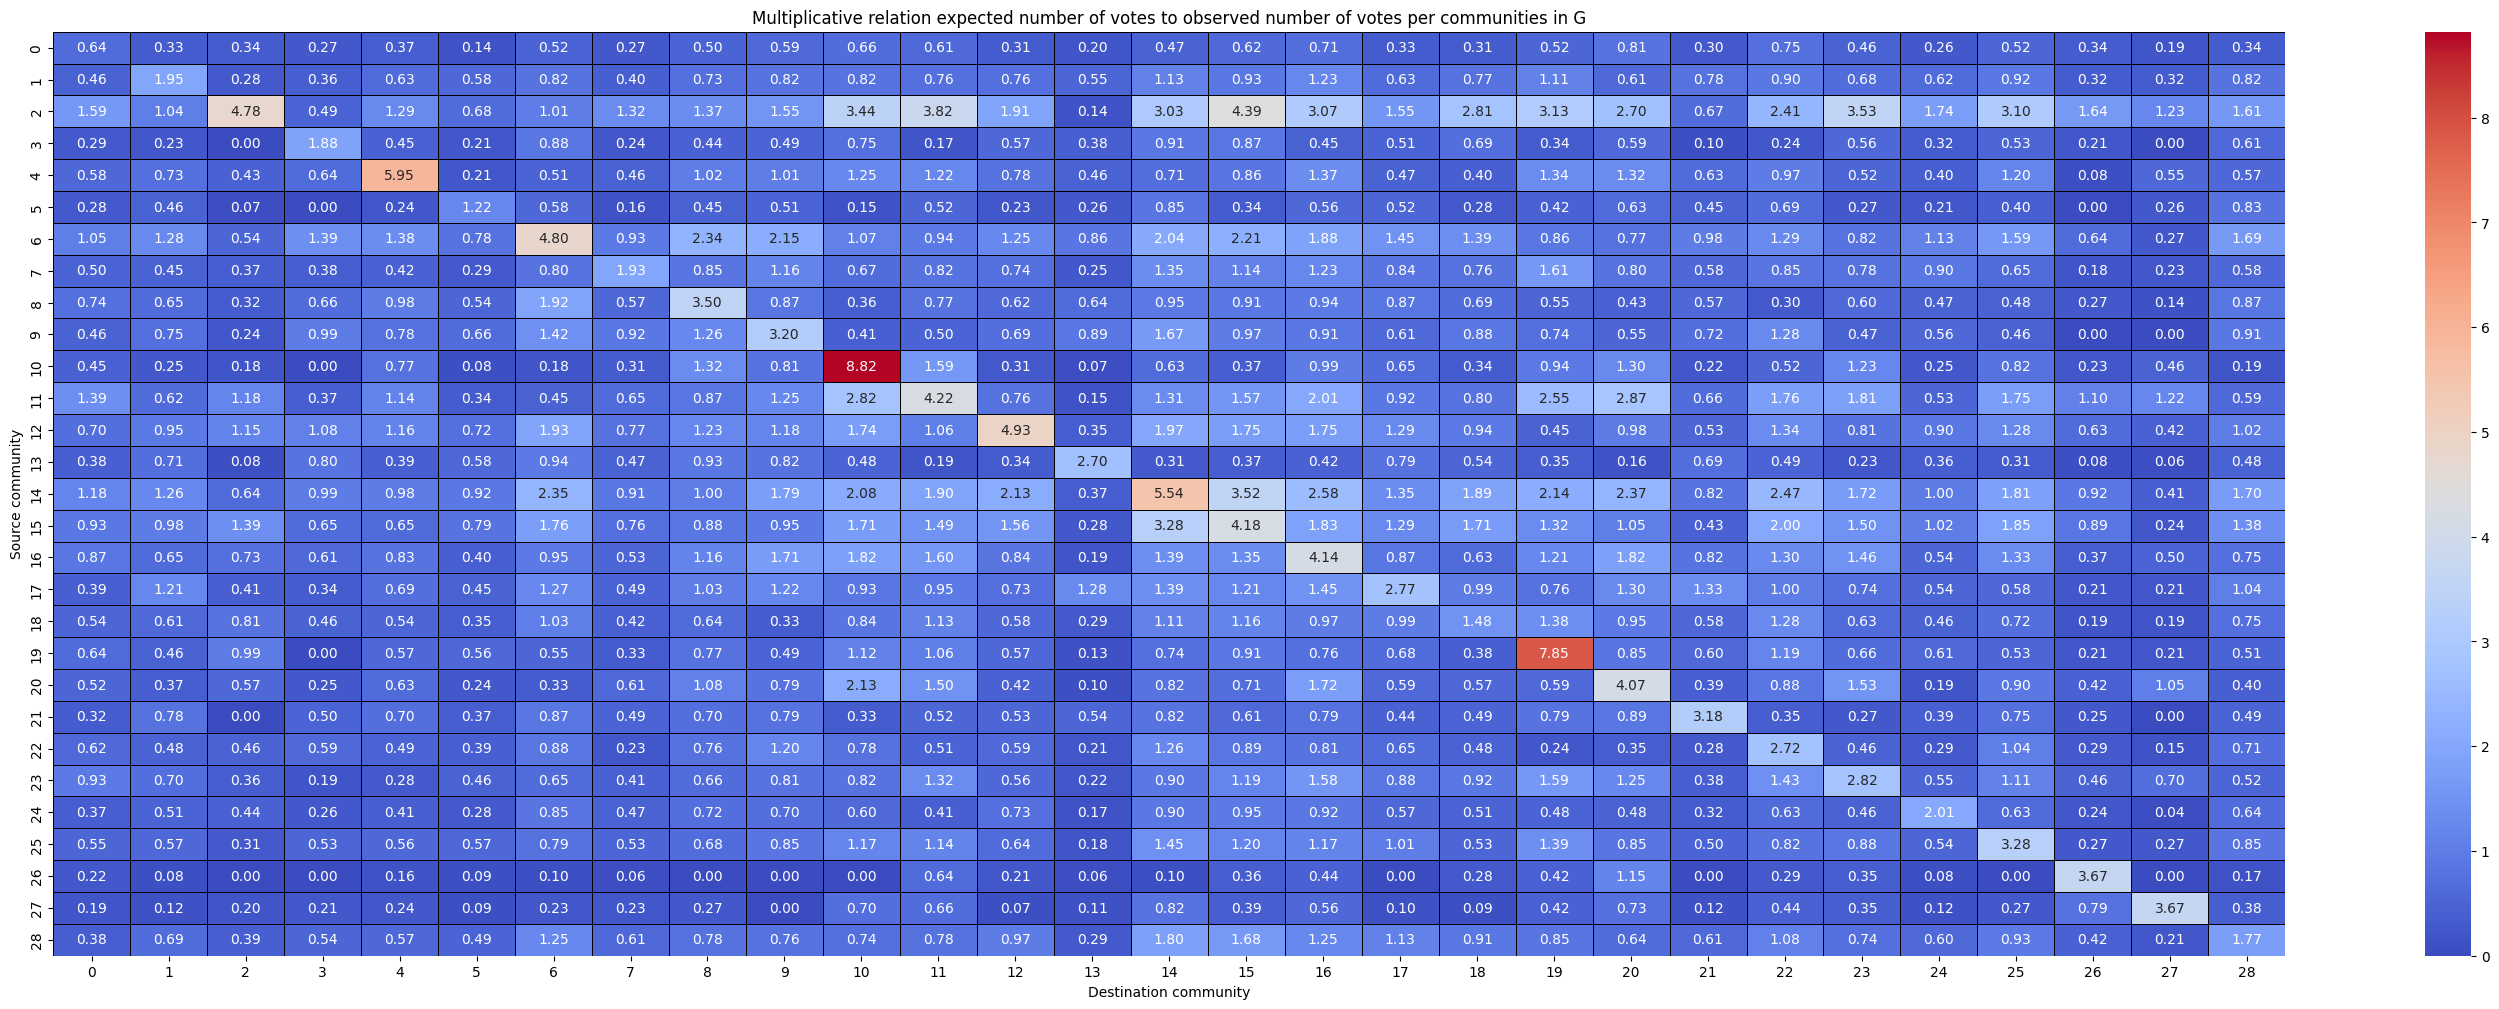

In [27]:
# Heatmap of the gain from expected votes across communities
# Couleurs sympas: 'PuBuGn', 'RdYlBu', 'coolwarm'
plt.figure(figsize=(36, 12))
sns.heatmap(gain_vote_expected_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, linecolor="black")
plt.title("Multiplicative relation expected number of votes to observed number of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

The diagonal of the matrix has significantly higher values. This indicates that people tend to vote more for the people part of their community. We recall that the communities have been created with the interactions between the users and not the votes.

#### Can we find a rivalry between some communities? Maybe a community only vote negatively towards another community.

We want to know the voting habitudes of communities. For that we plot the result precentage per community

In [28]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [29]:
vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100

/var/folders/4z/k7wkc9t97453h4tqprj_1j3h0000gn/T/ipykernel_40388/1177325575.py:1: RuntimeWarning: invalid value encountered in divide
  vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100


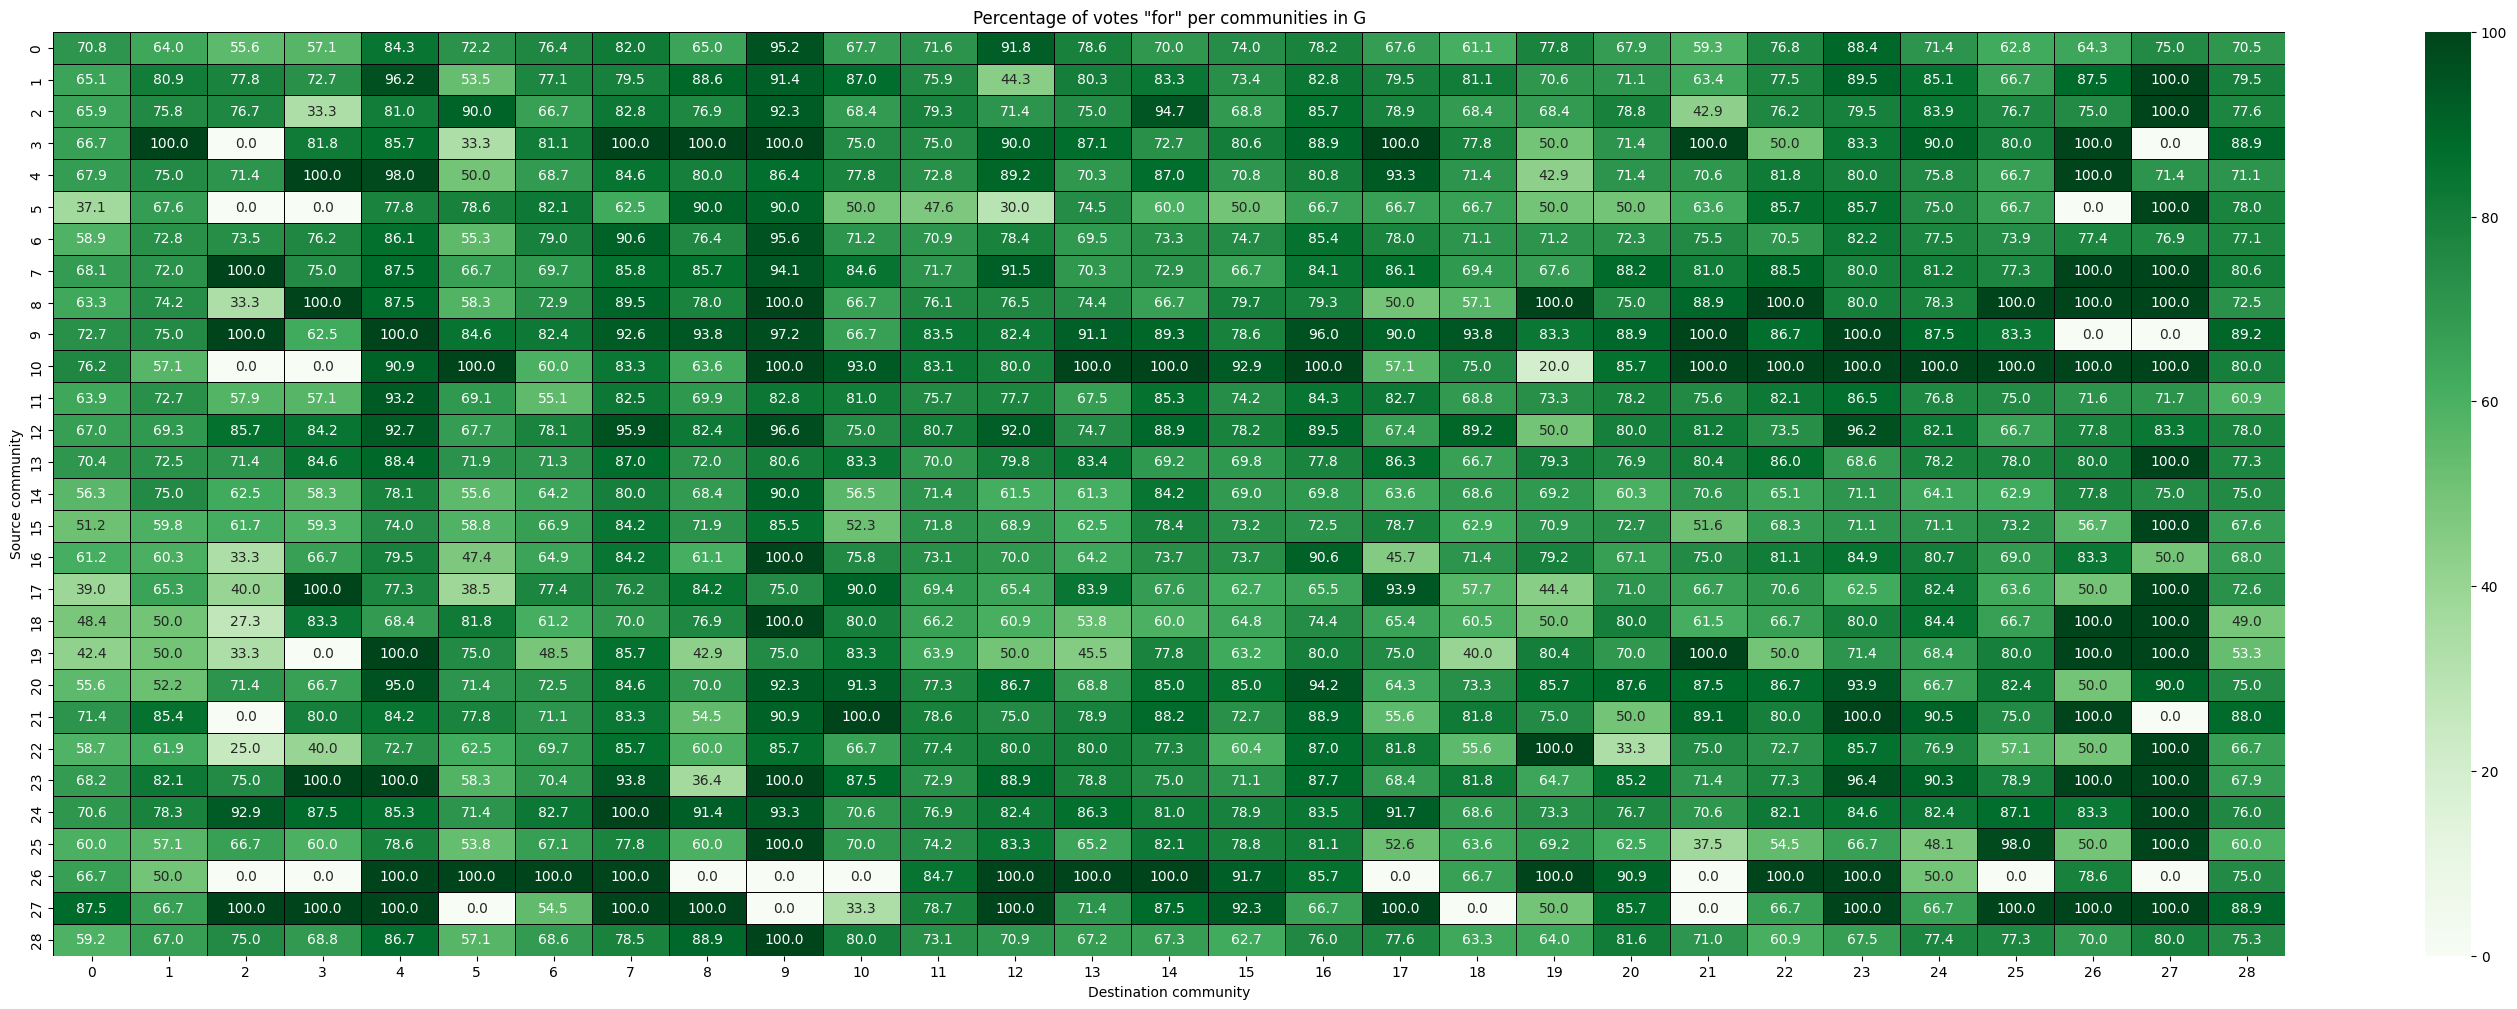

In [30]:
for_ratio_result_matrix = vote_result_matrix[:,:,2]
plt.figure(figsize=(36, 12))
sns.heatmap(for_ratio_result_matrix, cmap="Greens", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"for\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

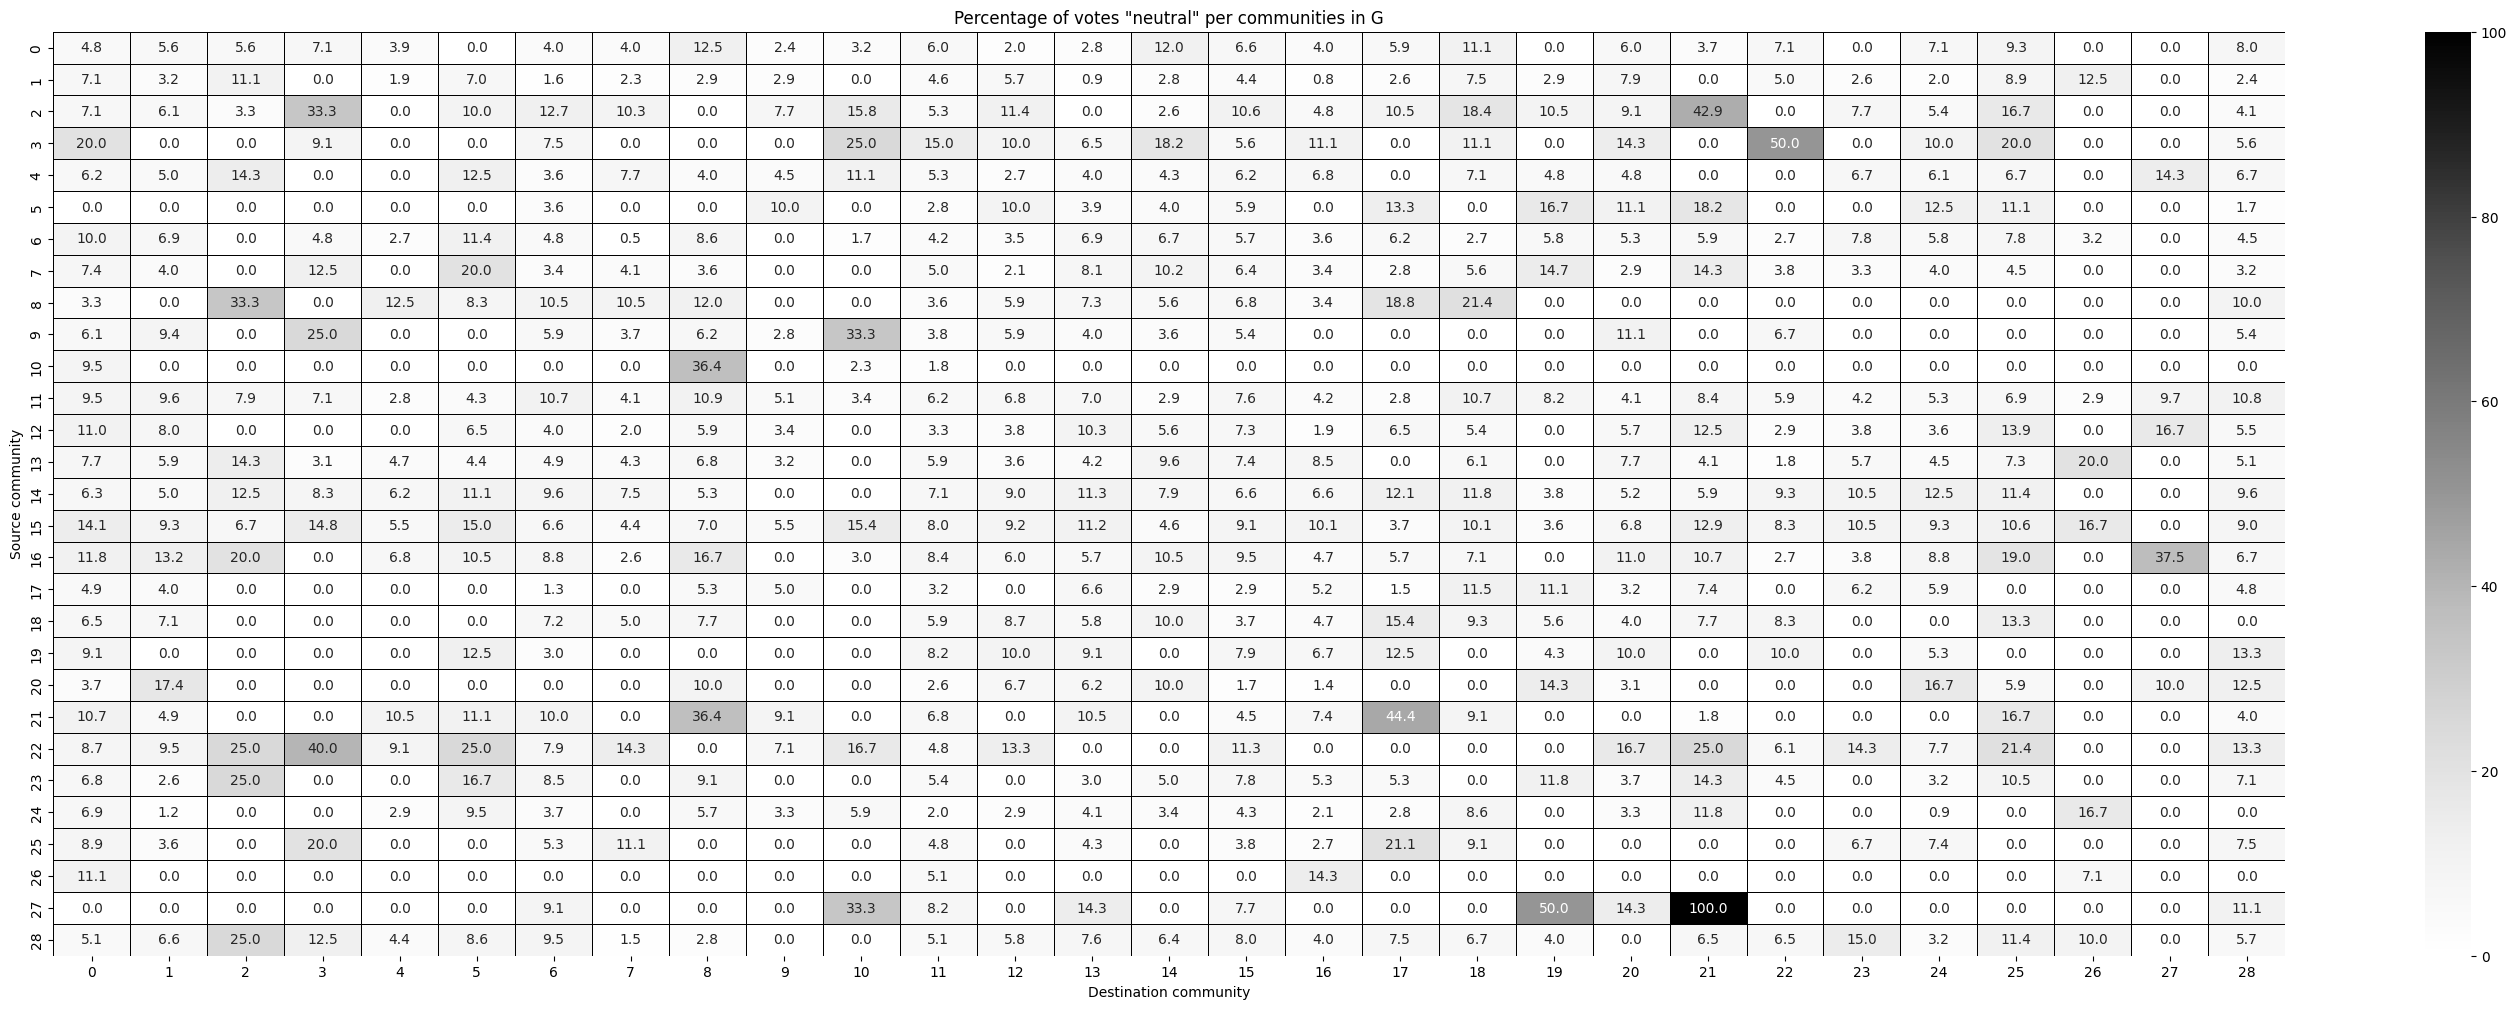

In [31]:
neutral_ratio_result_matrix = vote_result_matrix[:,:,1]
plt.figure(figsize=(36, 12))
sns.heatmap(neutral_ratio_result_matrix, cmap="Greys", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"neutral\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

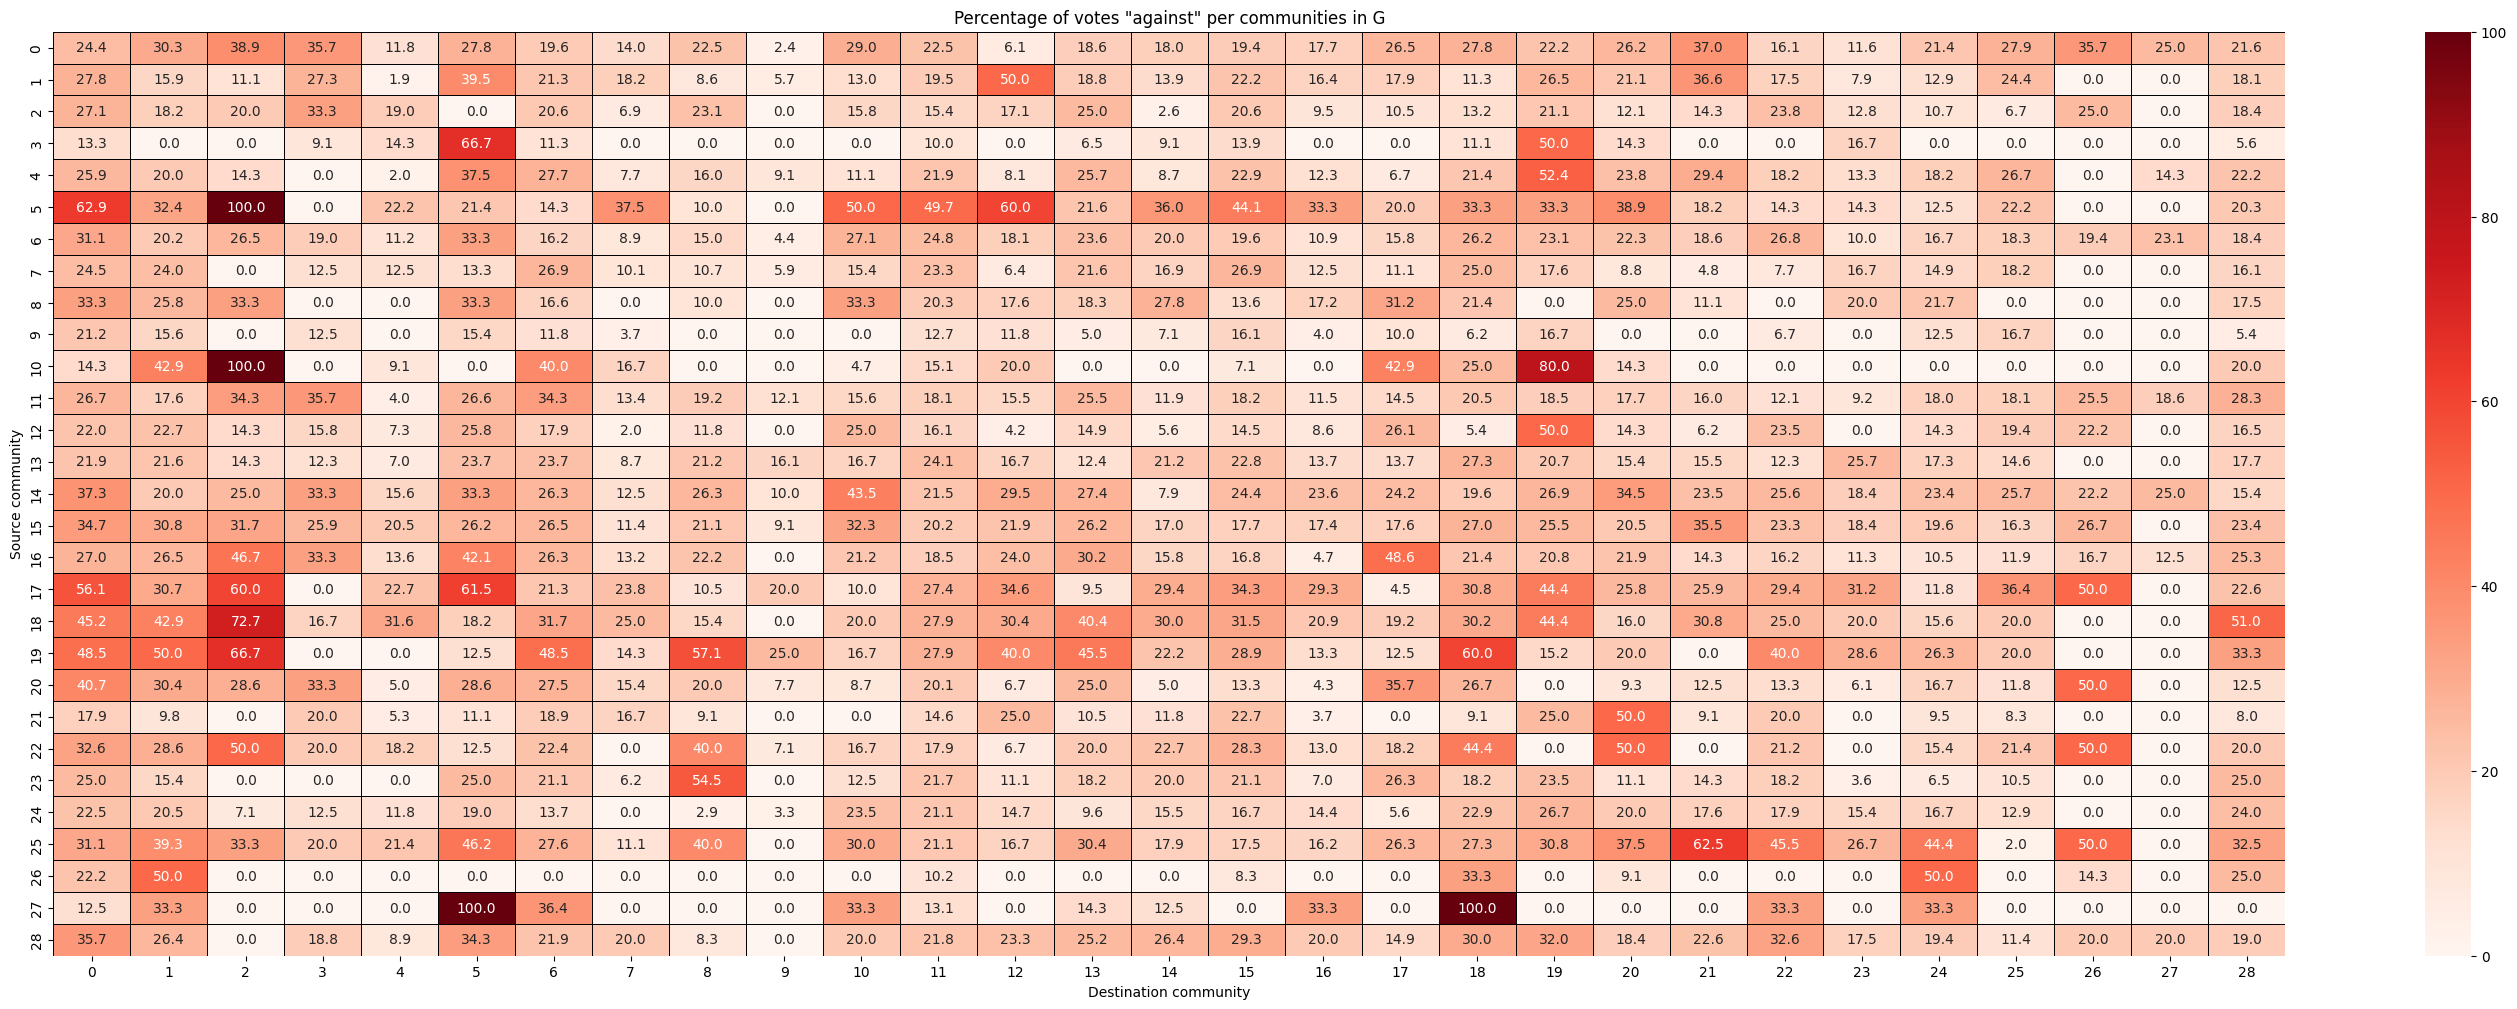

In [32]:
against_ratio_result_matrix = vote_result_matrix[:,:,0]
plt.figure(figsize=(36, 12))
sns.heatmap(against_ratio_result_matrix, cmap="Reds", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"against\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()